In [234]:
# === All necessary imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
# === Load the dataset ===
df = pd.read_csv('df_encoded.csv')  # Update file name as needed

# === Prepare feature set (drop both label columns for both models) ===
X = df.drop(columns=['label', 'attack_cat'])

# === Target for binary model ===
y_bin = df['label']

# === Split for binary model ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

In [223]:
df.shape

(2027332, 43)

In [224]:
df.head()

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,120,2,0.001055,132,164,31,29,0,0,1,...,0,3,7,1,3,1,1,1,6,0
1,120,2,0.036133,528,304,31,29,0,0,5,...,0,2,4,2,3,1,1,2,6,0
2,120,2,0.001119,146,178,31,29,0,0,1,...,0,12,8,1,2,2,1,1,6,0
3,120,2,0.001209,132,164,31,29,0,0,1,...,0,6,9,1,1,1,1,1,6,0
4,120,2,0.001169,146,178,31,29,0,0,1,...,0,7,9,1,1,1,1,1,6,0


In [245]:
# === XGBoost for Binary Classification ===
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42
}

In [246]:
clf_bin = XGBClassifier(**params)
clf_bin.fit(X_train, y_train)

# Predict on test set
y_pred_bin = clf_bin.predict(X_test)
y_proba_bin = clf_bin.predict_proba(X_test)[:, 1]  # Probability for class 1

C:\Users\alpba\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:12:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Binary Classification (is_attack):
Accuracy: 0.9919
F1 Score: 0.9059
Precision: 0.9204
Recall: 0.8919
ROC AUC: 0.999
              precision    recall  f1-score   support

           0     0.9951    0.9965    0.9958    581673
           1     0.9204    0.8919    0.9059     26527

    accuracy                         0.9919    608200
   macro avg     0.9577    0.9442    0.9509    608200
weighted avg     0.9918    0.9919    0.9919    608200



In [249]:
# Evaluate with multiple metrics
print("XGBoost - Binary Classification (is_attack):")
print("Accuracy:", round(accuracy_score(y_test, y_pred_bin), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_bin), 4))
print("Precision:", round(precision_score(y_test, y_pred_bin), 4))
print("Recall:", round(recall_score(y_test, y_pred_bin), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_bin), 4))
print(classification_report(y_test, y_pred_bin, digits=4))

XGBoost - Binary Classification (is_attack):
Accuracy: 0.9919
F1 Score: 0.9059
Precision: 0.9204
Recall: 0.8919
ROC AUC: 0.999
              precision    recall  f1-score   support

           0     0.9951    0.9965    0.9958    581673
           1     0.9204    0.8919    0.9059     26527

    accuracy                         0.9919    608200
   macro avg     0.9577    0.9442    0.9509    608200
weighted avg     0.9918    0.9919    0.9919    608200



In [251]:
# === Filter only attack samples for multiclass ===
df_attacks = df[df['label'] == 1].copy()
X_cat = df_attacks.drop(columns=['label', 'attack_cat'])
y_cat = df_attacks['attack_cat']

In [ ]:
# === Encode attack_cat if needed ===
le = LabelEncoder()
yc_train_enc = le.fit_transform(yc_train)
yc_test_enc  = le.transform(yc_test)

clf_cat = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
clf_cat.fit(Xc_train, yc_train_enc)


In [230]:
# === Split data for multiclass model ===
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cat, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
# Predict and probability
yc_pred = clf_cat.predict(Xc_test)
yc_proba = clf_cat.predict_proba(Xc_test)

# Evaluate with multiple metrics
print("XGBoost - Multiclass Classification (attack_cat):")
print("Accuracy:", round(accuracy_score(yc_test_enc, yc_pred), 4))
print("F1 Score (weighted):", round(f1_score(yc_test_enc, yc_pred, average='weighted'), 4))
print("Precision (weighted):", round(precision_score(yc_test_enc, yc_pred, average='weighted', zero_division=0), 4))
print("Recall (weighted):", round(recall_score(yc_test_enc, yc_pred, average='weighted', zero_division=0), 4))
print("ROC AUC (weighted):", round(roc_auc_score(
    yc_test_enc, yc_proba, multi_class='ovr', average='weighted'), 4))
print(classification_report(yc_test_enc, yc_pred, digits=4, target_names=[str(c) for c in le.classes_]))

C:\Users\alpba\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:56:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Multiclass Classification (attack_cat):
Accuracy: 0.7903
F1 Score (weighted): 0.7879
Precision (weighted): 0.7908
Recall (weighted): 0.7903
ROC AUC (weighted): 0.9694
              precision    recall  f1-score   support

           0     0.1463    0.2623    0.1878       610
           1     0.1469    0.1383    0.1425       564
           2     0.4128    0.2265    0.2925      1651
           3     0.8096    0.8636    0.8357      8231
           4     0.8783    0.9021    0.8900      6290
           5     0.9091    0.8750    0.8918      5658
           7     0.8091    0.7484    0.7775      3036
           8     0.6911    0.7323    0.7111       437
           9     0.6750    0.5294    0.5934        51

    accuracy                         0.7903     26528
   macro avg     0.6087    0.5864    0.5914     26528
weighted avg     0.7908    0.7903    0.7879     26528



In [197]:
# Confirm labels and classes
print("Attack category classes:", le.classes_)
print("Train distribution:", np.unique(y2_train_enc, return_counts=True))
print("Test distribution:", np.unique(y2_test_enc, return_counts=True))
print("Prediction distribution:", np.unique(y2_pred, return_counts=True))

Attack category classes: [0 1 2 3 4 5 7 8 9]
Train distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([ 1423,  1317,  3851, 19205, 14675, 13202,  7082,  1021,   120],
      dtype=int64))
Test distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([ 610,  564, 1651, 8231, 6290, 5658, 3036,  437,   51], dtype=int64))
Prediction distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([1094,  531,  906, 8780, 6460, 5446, 2808,  463,   40], dtype=int64))


Confusion Matrix (Binary):
 [[579627   2046]
 [  2867  23660]]


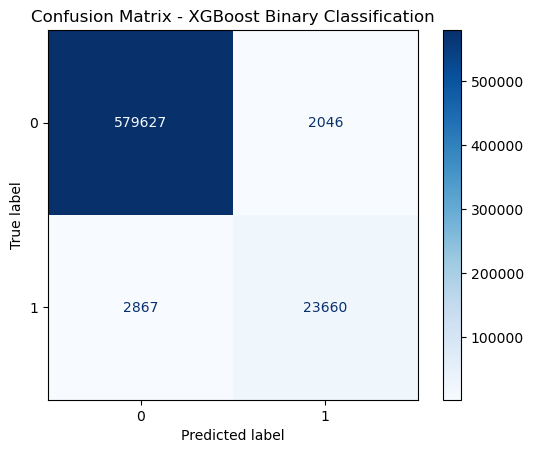

In [240]:
# After making predictions (e.g., y_pred_bin)
cm_bin = confusion_matrix(y_test, y_pred_bin)
print("Confusion Matrix (Binary):\n", cm_bin)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost Binary Classification")
plt.show()

Confusion Matrix (Multiclass):
 [[ 160   94   82   98   92   44   40    0    0]
 [ 146   78   59   70   92   50   64    5    0]
 [ 162   78  374  687  136   90   70   54    0]
 [ 183   85  176 7108  206  153  267   46    7]
 [ 167   91   74  144 5674   77   42   20    1]
 [ 142   52   76  255  114 4951   51   12    5]
 [ 134   53   61  351   93   66 2272    6    0]
 [   0    0    4   45   53   13    2  320    0]
 [   0    0    0   22    0    2    0    0   27]]


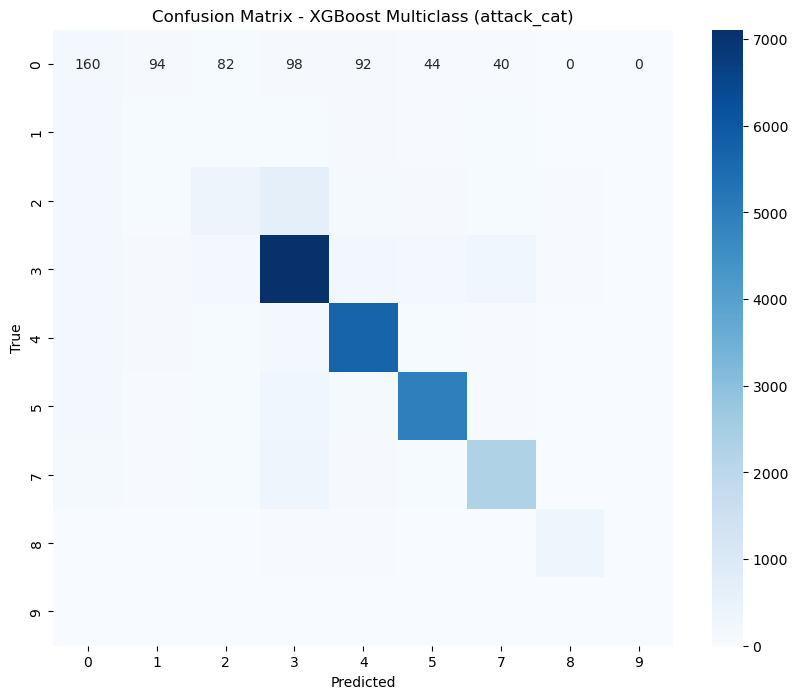

In [242]:
# After making predictions (e.g., yc_pred, yc_test_enc)
cm_multi = confusion_matrix(yc_test_enc, yc_pred)
print("Confusion Matrix (Multiclass):\n", cm_multi)

# Visualize with matplotlib (or use seaborn for nicer colors)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix - XGBoost Multiclass (attack_cat)")
plt.show()